In [7]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    x = x.astype('float')

    #normalize each example in x to have 0 mean and 1 std
    
    # Calculate the mean and standard deviation for each feature
    feature_means = np.mean(x, axis=0)
    feature_stds = np.std(x, axis=0)
    feature_stds = feature_stds + (feature_stds == 0)

    # Normalize each feature to have 0 mean and 1 std
    x = (x - feature_means) / (feature_stds)
    
    # Adjust labels to start from 0 if they start from 1
    y = y - 1
    
    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

In [166]:
x_test, y_test = get_data('x_test.npy', 'y_test.npy')
x_train, y_train = get_data('x_train.npy', 'y_train.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 1024), (10000,), (1000, 1024), (1000,))

In [167]:
x_train[0]

array([-0.39813868,  0.1879447 ,  0.91463024, ..., -0.15117837,
        0.26519742,  0.        ])

In [168]:
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))

y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))

In [169]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        Initializes the neural network with the given layer sizes.
        layer_sizes is a list of integers, where the i-th integer represents
        the number of neurons in the i-th layer.
        """
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weights are initialized with small random values
            self.weights.append(np.random.randn(layer_sizes[i+1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((layer_sizes[i+1], 1)))

    def sigmoid(self, z):
        """
        The sigmoid activation function.
        """
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        """
        The softmax function.
        """
        e_z = np.exp(z)  # Subtracting np.max(z) for numerical stability
        return e_z / e_z.sum(axis=0, keepdims=True)

    def feedforward(self, x):
        """
        Performs a feedforward computation.
        """
        activation = x
        self.activations = [x]  # List to store all the activations, layer by layer

        # Compute activations for each layer
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            activation = self.sigmoid(z) if w is not self.weights[-1] else self.softmax(z)
            self.activations.append(activation)

        return self.activations[-1]  # The final activation is the output of the network

# Let's test the initialization and feedforward computation with a small network
nn = NeuralNetwork([1024, 100, 5])  # A network with 1024 input features, one hidden layer with 100 neurons, and 5 output classes
sample_input = np.random.randn(1024, 1)  # A random sample input
output = nn.feedforward(sample_input)  # Perform a feedforward computation

output  # Display the output probabilities

array([[0.21001698],
       [0.18440967],
       [0.20223693],
       [0.20182329],
       [0.20151313]])

In [173]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def cross_entropy_loss(self, y_pred, y_true):
        """
        Computes the cross-entropy loss.
        """
        m = y_true.shape[1]  # Number of examples
        # To avoid division by zero, we clip the predictions to a minimum value
        # y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def backpropagation(self, y_true):
        """
        Performs backpropagation to compute the gradients of the loss function
        with respect to the weights and biases.
        """
        m = y_true.shape[1]  # Number of examples
        y_pred = self.activations[-1]  # The output of the last layer
        y_true = y_true.reshape(y_pred.shape)  # Ensure same shape

        # Initialize gradients for each layer
        d_weights = [np.zeros(w.shape) for w in self.weights]
        d_biases = [np.zeros(b.shape) for b in self.biases]

        # Calculate derivative of loss w.r.t. the last layer output
        d_loss = y_pred - y_true

        for i in reversed(range(len(d_weights))):
            d_activations = d_loss * self.sigmoid_derivative(self.activations[i+1]) if i != len(d_weights) - 1 else d_loss
            d_weights[i] = np.dot(d_activations, self.activations[i].T) / m
            d_biases[i] = np.sum(d_activations, axis=1, keepdims=True) / m
            if i != 0:
                d_loss = np.dot(self.weights[i].T, d_activations)

        return d_weights, d_biases

    def sigmoid_derivative(self, s):
        """
        Derivative of the sigmoid function.
        """
        return s * (1 - s)

    def update_parameters(self, d_weights, d_biases, learning_rate):
        """
        Updates the parameters using the computed gradients.
        """
        # Update each parameter with a simple gradient descent step
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * d_weights[i]
            self.biases[i] -= learning_rate * d_biases[i]
            
    def train(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        for epoch in range(epochs):
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)
            
            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
            
            loss_history.append(loss)
            
            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if np.std(temp) < conv_threshold:
                    print('Converged')
                    break

In [174]:
# Create a fresh instance of the neural network with the corrected train method
nn = NeuralNetwork([1024, 100, 5])
# Convert labels to one-hot encoding again
y_train_one_hot = np.eye(5)[y_train].T

# Train the neural network again with the corrected training method
nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)

Epoch 1/1000, Loss: 1.3209
Epoch 2/1000, Loss: 0.9888
Epoch 3/1000, Loss: 0.8633
Epoch 4/1000, Loss: 0.7913
Epoch 5/1000, Loss: 0.7416
Epoch 6/1000, Loss: 0.7035
Epoch 7/1000, Loss: 0.6723
Epoch 8/1000, Loss: 0.6458
Epoch 9/1000, Loss: 0.6226
Epoch 10/1000, Loss: 0.6021
Epoch 11/1000, Loss: 0.5837
Epoch 12/1000, Loss: 0.5670
Epoch 13/1000, Loss: 0.5519
Epoch 14/1000, Loss: 0.5381
Epoch 15/1000, Loss: 0.5255
Epoch 16/1000, Loss: 0.5138
Epoch 17/1000, Loss: 0.5030
Epoch 18/1000, Loss: 0.4930
Epoch 19/1000, Loss: 0.4837
Epoch 20/1000, Loss: 0.4749
Epoch 21/1000, Loss: 0.4667
Epoch 22/1000, Loss: 0.4590
Epoch 23/1000, Loss: 0.4517
Epoch 24/1000, Loss: 0.4448
Epoch 25/1000, Loss: 0.4383
Epoch 26/1000, Loss: 0.4321
Epoch 27/1000, Loss: 0.4262
Epoch 28/1000, Loss: 0.4205
Epoch 29/1000, Loss: 0.4151
Epoch 30/1000, Loss: 0.4100
Epoch 31/1000, Loss: 0.4050
Epoch 32/1000, Loss: 0.4003
Epoch 33/1000, Loss: 0.3957
Epoch 34/1000, Loss: 0.3913
Epoch 35/1000, Loss: 0.3871
Epoch 36/1000, Loss: 0.3830
E

In [172]:
# Compute the accuracy on the training and test sets
y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
print(f"Training accuracy: {np.mean(y_train_pred == y_train) * 100}%")
print(f"Test accuracy: {np.mean(y_test_pred == y_test) * 100}%")

Training accuracy: 100.0%
Test accuracy: 86.2%


# part b

In [0]:
hidden_layer_sizes = [1, 5, 10, 50, 100]
model_with_hidden_layer_size = {}

for hidden_layer_size in hidden_layer_sizes:
    
    print(f'hidden_layer_size: {hidden_layer_size}')
    nn = NeuralNetwork([1024, hidden_layer_size, 5])
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layer_size[hidden_layer_size] = nn

In [183]:
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{hidden_layer_size} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

1 hidden layer size
Training
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      2589
           1       0.63      0.89      0.74      1410
           2       0.78      0.85      0.81      1782
           3       0.40      0.73      0.52      1114
           4       0.98      0.66      0.79      3105

    accuracy                           0.76     10000
   macro avg       0.76      0.78      0.74     10000
weighted avg       0.84      0.76      0.78     10000

Test
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       258
           1       0.73      0.91      0.81       158
           2       0.67      0.78      0.72       170
           3       0.32      0.55      0.40       107
           4       0.98      0.60      0.74       307

    accuracy                           0.75      1000
   macro avg       0.74      0.75      0.72      1000
weighted avg       0.82      0.75      0.76

In [184]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])
    
    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

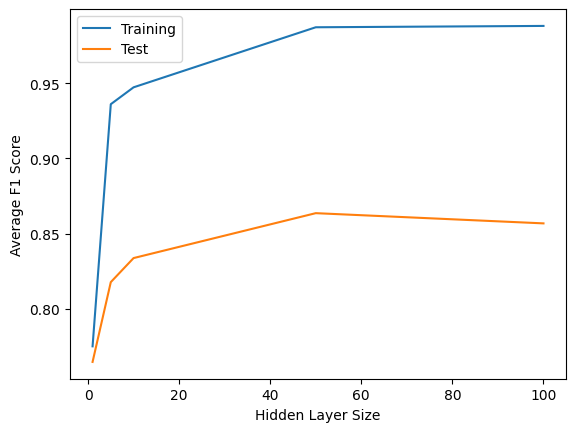

In [185]:
plt.plot(hidden_layer_sizes, avg_f1_scores_training, label = 'Training')
plt.plot(hidden_layer_sizes, avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(b) f1 vs hidden_size.png')

# part c

In [187]:
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
layers = [[1024] + hidden_layer + [5] for hidden_layer in hidden_layers]
model_with_hidden_layers = {}

for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 5]
Epoch 1/1000, Loss: 1.1081
Epoch 2/1000, Loss: 0.8564
Epoch 3/1000, Loss: 0.7482
Epoch 4/1000, Loss: 0.6855
Epoch 5/1000, Loss: 0.6427
Epoch 6/1000, Loss: 0.6103
Epoch 7/1000, Loss: 0.5843
Epoch 8/1000, Loss: 0.5624
Epoch 9/1000, Loss: 0.5435
Epoch 10/1000, Loss: 0.5269
Epoch 11/1000, Loss: 0.5121
Epoch 12/1000, Loss: 0.4989
Epoch 13/1000, Loss: 0.4869
Epoch 14/1000, Loss: 0.4761
Epoch 15/1000, Loss: 0.4662
Epoch 16/1000, Loss: 0.4572
Epoch 17/1000, Loss: 0.4490
Epoch 18/1000, Loss: 0.4414
Epoch 19/1000, Loss: 0.4343
Epoch 20/1000, Loss: 0.4278
Epoch 21/1000, Loss: 0.4218
Epoch 22/1000, Loss: 0.4161
Epoch 23/1000, Loss: 0.4108
Epoch 24/1000, Loss: 0.4059
Epoch 25/1000, Loss: 0.4012
Epoch 26/1000, Loss: 0.3967
Epoch 27/1000, Loss: 0.3925
Epoch 28/1000, Loss: 0.3885
Epoch 29/1000, Loss: 0.3847
Epoch 30/1000, Loss: 0.3810
Epoch 31/1000, Loss: 0.3775
Epoch 32/1000, Loss: 0.3741
Epoch 33/1000, Loss: 0.3709
Epoch 34/1000, Loss: 0.3678
Epoch 35/1000, Loss: 0.

In [203]:
for layer in layers[-2:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 256, 128, 5]
Epoch 1/200, Loss: 1.6101
Epoch 2/200, Loss: 1.6101
Epoch 3/200, Loss: 1.6101


KeyboardInterrupt: 

In [ ]:
for layer in layers[-1:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

In [ ]:
import pickle
with open('models_c.pickle', 'wb') as handle:
    pickle.dump(model_with_hidden_layers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load models

with open('models_c.pickle', 'rb') as handle:
    model_with_hidden_layers = pickle.load(handle)

In [ ]:
for layer in layers:
    nn = model_with_hidden_layers[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

In [ ]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for layer in layers:
    nn = model_with_hidden_layers[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])
    
    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])
    
plt.plot([len(layer) for layer in layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer) for layer in layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(c) f1 vs hidden_depth.png')
plt.show()

# part d

In [ ]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def train_c(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        learning_rate_c = learning_rate
        for epoch in range(epochs):
            learning_rate = learning_rate_c / pow(epoch+1, 0.5)
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)
            
            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
            
            loss_history.append(loss)
            
            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if np.std(temp) < conv_threshold:
                    print('Converged')
                    break

In [ ]:
models_d = {}
for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train_c(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01)
    models_d[str(layer)] = nn

In [ ]:
# save models
import pickle

with open('pickles/models_d.pickle', 'wb') as handle:
    pickle.dump(models_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# report results
for layer in layers:
    nn = models_d[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

In [ ]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for layer in layers:
    nn = models_d[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])
    
    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])
    
plt.plot([len(layer) for layer in layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer) for layer in layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(d) adaptive training f1 vs hidden_depth.png')
plt.show()

# part f

In [ ]:
from sklearn.metrics import f1_score
models_f = {}
for hidden_layer in hidden_layers:
    print(f'hidden_layer_size: {hidden_layer}')
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer,
                        activation='relu',
                        solver='sgd',
                        alpha=0,
                        batch_size=32,
                        learning_rate='invscaling',
                        max_iter=200,
                        n_iter_no_change=5,
                        verbose=True)
    mlp.fit(x_train, y_train)
    
    models_f[str(hidden_layer)] = mlp

hidden_layer_size: [512]
Iteration 1, loss = 0.84011246
Iteration 2, loss = 0.62304192
Iteration 3, loss = 0.58933066
Iteration 4, loss = 0.58147115
Iteration 5, loss = 0.57804912
Iteration 6, loss = 0.57594228
Iteration 7, loss = 0.57437926
Iteration 8, loss = 0.57312266
Iteration 9, loss = 0.57203400
Iteration 10, loss = 0.57107017
Iteration 11, loss = 0.57019680
Iteration 12, loss = 0.56939025
Iteration 13, loss = 0.56865138
Iteration 14, loss = 0.56796419
Iteration 15, loss = 0.56731128
Iteration 16, loss = 0.56670029
Iteration 17, loss = 0.56611758
Iteration 18, loss = 0.56556786
Iteration 19, loss = 0.56504157
Iteration 20, loss = 0.56453699
Iteration 21, loss = 0.56405597
Iteration 22, loss = 0.56358632
Iteration 23, loss = 0.56314046
Iteration 24, loss = 0.56270575
Iteration 25, loss = 0.56228673
Iteration 26, loss = 0.56188335
Iteration 27, loss = 0.56148425
Iteration 28, loss = 0.56110012
Iteration 29, loss = 0.56072995
Iteration 30, loss = 0.56036620
Iteration 31, loss = 0.5

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.85672505
Iteration 2, loss = 0.57621906
Iteration 3, loss = 0.56522245
Iteration 4, loss = 0.56076681
Iteration 5, loss = 0.55821352
Iteration 6, loss = 0.55644576
Iteration 7, loss = 0.55510073
Iteration 8, loss = 0.55399327
Iteration 9, loss = 0.55303944
Iteration 10, loss = 0.55218222
Iteration 11, loss = 0.55140449
Iteration 12, loss = 0.55069223
Iteration 13, loss = 0.55001727
Iteration 14, loss = 0.54938848
Iteration 15, loss = 0.54878234
Iteration 16, loss = 0.54821338
Iteration 17, loss = 0.54766797
Iteration 18, loss = 0.54714223
Iteration 19, loss = 0.54663095
Iteration 20, loss = 0.54614263
Iteration 21, loss = 0.54567043
Iteration 22, loss = 0.54521485
Iteration 23, loss = 0.54477262
Iteration 24, loss = 0.54433575
Iteration 25, loss = 0.54391401
Iteration 26, loss = 0.54350091
Iteration 27, loss = 0.54310375
Iteration 28, loss = 0.54271051
Iteration 29, loss = 0.54232951
Iteration 30, loss = 0.54195140
Iteration 31, loss = 0.54158502
Iteration 32, los

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.83786005
Iteration 2, loss = 0.53631445
Iteration 3, loss = 0.53262650
Iteration 4, loss = 0.53070630
Iteration 5, loss = 0.52921184
Iteration 6, loss = 0.52792814
Iteration 7, loss = 0.52680088
Iteration 8, loss = 0.52576838
Iteration 9, loss = 0.52482025
Iteration 10, loss = 0.52394015
Iteration 11, loss = 0.52310287
Iteration 12, loss = 0.52233403
Iteration 13, loss = 0.52159424
Iteration 14, loss = 0.52089123
Iteration 15, loss = 0.52021255
Iteration 16, loss = 0.51957148
Iteration 17, loss = 0.51894691
Iteration 18, loss = 0.51835595
Iteration 19, loss = 0.51777435
Iteration 20, loss = 0.51721581
Iteration 21, loss = 0.51667558
Iteration 22, loss = 0.51613723
Iteration 23, loss = 0.51563321
Iteration 24, loss = 0.51512665
Iteration 25, loss = 0.51463847
Iteration 26, loss = 0.51416003
Iteration 27, loss = 0.51369737
Iteration 28, loss = 0.51324175
Iteration 29, loss = 0.51279439
Iteration 30, loss = 0.51236081
Iteration 31, loss = 0.51192900
Iteration 32, los

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.90930399
Iteration 2, loss = 0.60190621
Iteration 3, loss = 0.53674433
Iteration 4, loss = 0.52880154
Iteration 5, loss = 0.52567206
Iteration 6, loss = 0.52374652
Iteration 7, loss = 0.52226000
Iteration 8, loss = 0.52100844
Iteration 9, loss = 0.51990123
Iteration 10, loss = 0.51890331
Iteration 11, loss = 0.51796550
Iteration 12, loss = 0.51707890
Iteration 13, loss = 0.51624444
Iteration 14, loss = 0.51545149
Iteration 15, loss = 0.51470449
Iteration 16, loss = 0.51397869
Iteration 17, loss = 0.51328775
Iteration 18, loss = 0.51260802
Iteration 19, loss = 0.51196275
Iteration 20, loss = 0.51133686
Iteration 21, loss = 0.51072778
Iteration 22, loss = 0.51014251
Iteration 23, loss = 0.50956066
Iteration 24, loss = 0.50901132
Iteration 25, loss = 0.50846365
Iteration 26, loss = 0.50792510
Iteration 27, loss = 0.50741484
Iteration 28, loss = 0.50689086
Iteration 29, loss = 0.50639249
Iteration 30, loss = 0.50591384
Iteration 31, loss = 0.50543321
Iteration 32, los

In [210]:
for hidden_layer in hidden_layers[-2:]:
    print(f'hidden_layer_size: {hidden_layer}')
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer,
                        activation='relu',
                        solver='sgd',
                        alpha=0,
                        batch_size=32,
                        learning_rate='invscaling',
                        max_iter=200,
                        n_iter_no_change=5,
                        verbose=True)
    mlp.fit(x_train, y_train)
    
    models_f[str(hidden_layer)] = mlp

hidden_layer_size: [512, 256, 128]
Iteration 1, loss = 0.87514613
Iteration 2, loss = 0.54215932
Iteration 3, loss = 0.53186683
Iteration 4, loss = 0.52898992
Iteration 5, loss = 0.52726676
Iteration 6, loss = 0.52591673
Iteration 7, loss = 0.52474353
Iteration 8, loss = 0.52366832
Iteration 9, loss = 0.52269450
Iteration 10, loss = 0.52178630
Iteration 11, loss = 0.52093355
Iteration 12, loss = 0.52013140
Iteration 13, loss = 0.51937098
Iteration 14, loss = 0.51864888
Iteration 15, loss = 0.51795255
Iteration 16, loss = 0.51728424
Iteration 17, loss = 0.51664530
Iteration 18, loss = 0.51602793
Iteration 19, loss = 0.51543852
Iteration 20, loss = 0.51486126
Iteration 21, loss = 0.51429758
Iteration 22, loss = 0.51375710
Iteration 23, loss = 0.51322473
Iteration 24, loss = 0.51270992
Iteration 25, loss = 0.51220830
Iteration 26, loss = 0.51171612
Iteration 27, loss = 0.51123707
Iteration 28, loss = 0.51077062
Iteration 29, loss = 0.51031305
Iteration 30, loss = 0.50986139
Iteration 31, 

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.88384739
Iteration 2, loss = 0.52783294
Iteration 3, loss = 0.52314994
Iteration 4, loss = 0.52067399
Iteration 5, loss = 0.51888259
Iteration 6, loss = 0.51739704
Iteration 7, loss = 0.51610765
Iteration 8, loss = 0.51498103
Iteration 9, loss = 0.51392380
Iteration 10, loss = 0.51297233
Iteration 11, loss = 0.51208177
Iteration 12, loss = 0.51124432
Iteration 13, loss = 0.51043616
Iteration 14, loss = 0.50967090
Iteration 15, loss = 0.50894539
Iteration 16, loss = 0.50824690
Iteration 17, loss = 0.50757261
Iteration 18, loss = 0.50693315
Iteration 19, loss = 0.50630039
Iteration 20, loss = 0.50570229
Iteration 21, loss = 0.50511680
Iteration 22, loss = 0.50453618
Iteration 23, loss = 0.50398529
Iteration 24, loss = 0.50344973
Iteration 25, loss = 0.50291882
Iteration 26, loss = 0.50240439
Iteration 27, loss = 0.50190257
Iteration 28, loss = 0.50140949
Iteration 29, loss = 0.50092840
Iteration 30, loss = 0.50046641
Iteration 31, loss = 0.50000484
Iteration 32, los

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [214]:
# save models
import pickle

with open('pickles/models_f.pickle', 'wb') as handle:
    pickle.dump(models_f, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# load models
import pickle
with open('pickles/models_f.pickle', 'rb') as handle:
    models_f = pickle.load(handle)

In [3]:
print(models_f)

{'[512]': MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=[512],
              learning_rate='invscaling', n_iter_no_change=5, solver='sgd',
              verbose=True), '[512, 256]': MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=[512, 256],
              learning_rate='invscaling', n_iter_no_change=5, solver='sgd',
              verbose=True), '[512, 256, 128]': MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=[512, 256, 128],
              learning_rate='invscaling', n_iter_no_change=5, solver='sgd',
              verbose=True), '[512, 256, 128, 64]': MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=[512, 256, 128, 64],
              learning_rate='invscaling', n_iter_no_change=5, solver='sgd',
              verbose=True)}


In [216]:
# predict
for hidden_layer in hidden_layers:
    mlp = models_f[str(hidden_layer)]
    y_train_pred = mlp.predict(x_train)
    y_test_pred = mlp.predict(x_test)
    results = classification_report(y_train_pred, y_train)
    print(f"{hidden_layer} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

[512] hidden layer size
Training
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2042
           1       0.82      0.82      0.82      1976
           2       0.69      0.71      0.70      1906
           3       0.66      0.69      0.68      1913
           4       0.86      0.83      0.84      2163

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Test
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       214
           1       0.80      0.77      0.78       206
           2       0.61      0.66      0.63       183
           3       0.59      0.62      0.61       179
           4       0.87      0.74      0.80       218

    accuracy                           0.76      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.77      0.76      

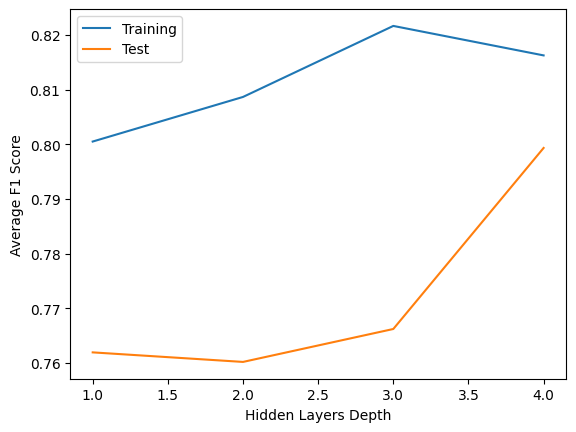

In [8]:
# plot avg f1 score
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
x_train, y_train = get_data('x_train.npy', 'y_train.npy')
x_test, y_test = get_data('x_test.npy', 'y_test.npy')

avg_f1_scores_training = []
avg_f1_scores_test = []

for hidden_layer in hidden_layers:
    mlp = models_f[str(hidden_layer)]
    y_train_pred = mlp.predict(x_train)
    y_test_pred = mlp.predict(x_test)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])
    
    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

plt.plot([len(layer) for layer in hidden_layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer) for layer in hidden_layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(f) f1 vs hidden_depth.png')
plt.show()